In [194]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import pickle


In [195]:
# --- Load data ---
df = pd.read_csv("../data/customer_prepped.csv", parse_dates=["sale_date"])
df = df.sort_values("sale_date")
# Rolling features
df["rolling_mean_7"] = df["total_value"].rolling(window=7).mean()
df["rolling_sum_7"] = df["total_value"].rolling(window=7).sum()
df["rolling_std_7"] = df["total_value"].rolling(window=7).std()

df["rolling_mean_30"] = df["total_value"].rolling(window=30).mean()
df["rolling_sum_30"] = df["total_value"].rolling(window=30).sum()
df["rolling_std_30"] = df["total_value"].rolling(window=30).std()

df = df.dropna()


In [196]:
for col in ["rolling_mean_7","rolling_sum_7","rolling_std_7",
            "rolling_mean_30","rolling_sum_30","rolling_std_30"]:
    df[col] = df[col].shift(1)


In [197]:
drop_cols = [
    "total_value", "sale_id", "customer_id", "product_id",
    "sale_date", "last_purchase_date", 
    "feedback_text", "tokens", "sentiment", 'quantity', 'price'
]

X = df.drop(columns=drop_cols)
y = np.log1p(df["total_value"])

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, shuffle=False
# )


In [198]:
# from xgboost import XGBRegressor

# xgb = XGBRegressor(
#     n_estimators=500,
#     learning_rate=0.05,
#     max_depth=6,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42
# )
# xgb.fit(X_train, y_train)

# y_pred_xgb = xgb.predict(X_test)

# print("XGBoost")
# print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
# print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
# print("R²:", r2_score(y_test, y_pred_xgb))


In [199]:
# plot_df = pd.DataFrame({
#     "Date": df.loc[y_test.index, "sale_date"],   # use loc, not iloc
#     "Actual": np.expm1(y_test),
#     "Predicted": np.expm1(y_pred_xgb)
# })
# y_test_reset = y_test.reset_index(drop=True)
# y_pred_reset = pd.Series(y_pred_xgb).reset_index(drop=True)
# dates_reset = df.loc[y_test.index, "sale_date"].reset_index(drop=True)

# plot_df = pd.DataFrame({
#     "Date": dates_reset,
#     "Actual": np.expm1(y_test_reset),
#     "Predicted": np.expm1(y_pred_reset)
# })
# # --- Full plot ---
# plt.figure(figsize=(14,6))
# plt.plot(plot_df["Date"], plot_df["Actual"], label="Actual", color="black", linewidth=2)
# plt.plot(plot_df["Date"], plot_df["Predicted"], label="Predicted", color="orange", linestyle="--")
# plt.title("XGBoost Forecast vs Actual Over Time")
# plt.xlabel("Date")
# plt.ylabel("Total Value")
# plt.legend()
# plt.grid(True)
# plt.show()

# # --- Zoomed-in (last 100 points) ---
# plt.figure(figsize=(14,6))
# plt.plot(plot_df["Date"].iloc[-100:], plot_df["Actual"].iloc[-100:], 
#          label="Actual", color="black", linewidth=2)
# plt.plot(plot_df["Date"].iloc[-100:], plot_df["Predicted"].iloc[-100:], 
#          label="Predicted", color="orange", linestyle="--")
# plt.title("XGBoost Forecast vs Actual (Last 100 Points)")
# plt.xlabel("Date")
# plt.ylabel("Total Value")
# plt.legend()
# plt.grid(True)
# plt.show()


Linear Regression
RMSE: 0.5618164368806906
MAE: 0.47610803266859975
R²: 0.94493697234081


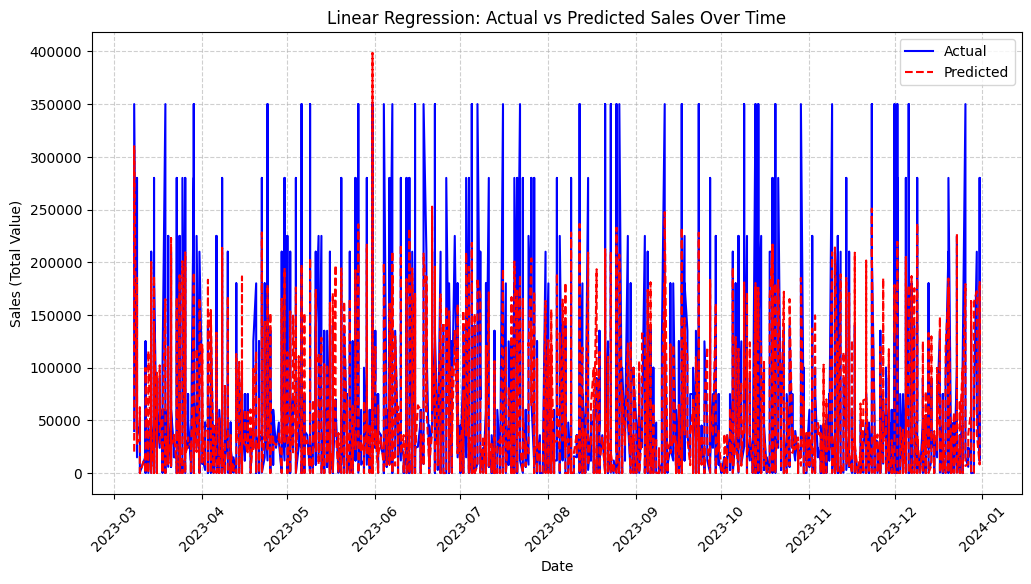

In [200]:
X = X.dropna()
y = y.loc[X.index]   # keep target aligned

# Split including dates
dates = df["sale_date"]
dates = dates.loc[X.index]

X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(
    X, y, dates, test_size=0.2, shuffle=False
)

# Fit Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predictions
y_pred_lr = lin_reg.predict(X_test)

# Evaluation
print("Linear Regression")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("R²:", r2_score(y_test, y_pred_lr))

# Plot
plt.figure(figsize=(12,6))
plt.plot(dates_test, np.expm1(y_test), label="Actual", color="blue")
plt.plot(dates_test, np.expm1(y_pred_lr), label="Predicted", color="red", linestyle="--")
plt.xlabel("Date")
plt.ylabel("Sales (Total Value)")
plt.title("Linear Regression: Actual vs Predicted Sales Over Time")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [201]:
# Save the model
with open("../models/linear_reg.pkl", "wb") as f:
    pickle.dump(lin_reg, f)

print("Model saved to models/linear_reg.pkl")

Model saved to models/linear_reg.pkl


In [202]:
# Build a DataFrame with dates, actuals, predictions
results_df = pd.DataFrame({
    "Date": dates_test.values,
    "Actual_Sales": np.expm1(y_test),       # undo log transform if applied
    "Predicted_Sales": np.expm1(y_pred_lr)  # same scaling
})

# Save to CSV
results_df.to_csv("../data/linear_reg_predictions.csv", index=False)

print("Predictions saved to data/linear_reg_predictions.csv")


Predictions saved to data/linear_reg_predictions.csv
